In [1]:
from dotenv import load_dotenv
import sys

sys.path.append("../../common")
load_dotenv()

True

In [2]:
import os
from langsmith_tracker import set_tracking

# 인스턴스를 생성할 때 필요한 매개변수를 전달합니다.
set_tracking(project_name="17.LangGraph-Use-Case")

Langsmith 추적이 활성화되었습니다. [프로젝트명: 17.LangGraph-Use-Case]


## Self-RAG

[LnagGraph 공식문서](https://langchain-ai.github.io/langgraph/)

Self-RAG 는 검색된 문서와 생성된 응답에 대한 자기 반성(self-reflection) 및 자기 평가(self-evaluation)를 포함한 RAG 전략입니다.  
RAG 시스템 성능 향상 효과가 있습니다.  

---

#### Self-RAG 란 무엇인가?

Self-RAG 는 검색된 문서와 생성된 응답 모두에 대해 점검하고 검증하는 추가 단계를 포함하는 RAG 전략입니다.  
전통적인 RAG에서는 검색된 정보를 기반으로 LLM이 답변을 생성하는 것이 주된 과정이었다면, Self-RAG에서는 자체 평가를 통해 다음과 같은 사항을 검증합니다.

1. 검색할 필요성 판단: 현재 질문에 대해 추가 검색이 필요한지 여부를 판단합니다.
2. 검색 결과 관련성 평가: 검색된 문서 조각(청크)이 질문 해결에 도움이 되는지 확인합니다.
3. 응답 사실성 검증: 생성된 답변이 제공된 문서 청크에 의해 충분히 뒷받침되는지 평가합니다.
4. 응답 품질 평가: 생성된 답변이 실제로 질문을 잘 해결하는지 측정합니다.
이 과정을 통해 단순히 검색하고 답변을 생성하는 단계를 넘어, 생성된 응답의 품질과 사실성을 스스로 모니터링하고 향상시킬 수 있습니다.

##### 그래프 흐름

![self-rag](./assets/langgraph_use_case_self_rag.png)

---

[Self-RAG 논문 바로가기](https://arxiv.org/abs/2310.11511)

#### 주요 개념 정리

논문에서는 Self-RAG를 통해 다음과 같은 결정 과정을 제안합니다.

1. Retriever 사용 여부 결정
    - 입력: x (question) 또는 (x (question), y (generation))
    - 출력: yes, no, continue  
    
    이 단계는 추가 검색을 진행할지, 검색 없이 그대로 진행할지, 혹은 더 기다려볼지 결정합니다.

2. 관련성 평가 (Retrieval Grader)
    - 입력: (x (question), d (chunk)) for each d in D
    - 출력: relevant 또는 irrelevant

    검색된 문서 청크들이 실제로 질문에 답하는데 유용한 정보인지 판별합니다.

3. 사실성 검증 (Hallucination Grader)

    - 입력: x (question), d (chunk), y (generation) for each d in D
    - 출력: {fully supported, partially supported, no support}

    생성된 응답이 검색 결과에 근거한 사실을 반영하는지, 혹은 환각(Hallucination)이 발생했는지 판단합니다.

4. 정답 품질 평가 (Answer Grader)

    - 입력: x (question), y (generation)
    - 출력: {5, 4, 3, 2, 1}

    생성된 응답이 질문을 어느 정도 해결하는지 점수화하여 평가합니다.


---

#### 이 튜토리얼에서 다룰 내용

이 튜토리얼은 LangGraph를 활용하여 Self-RAG 전략의 일부 아이디어를 구현하는 과정을 다룹니다.
다음과 같은 단계를 통해 Self-RAG 전략을 구축하고 실행하는 방법을 익히게 됩니다.

- Retriever: 문서를 검색
- Retrieval Grader: 검색된 문서의 관련성 평가
- Generate: 질문에 대한 답변 생성
- Hallucination Grader: 생성된 답변의 사실성(환각 여부) 검증
- Answer Grader: 답변의 질문에 대한 관련성 평가
- Question Re-writer: 쿼리 재작성
- 그래프 생성 및 실행: 정의한 노드로 그래프를 빌드하고 실행

### 기능 구현

#### PDF 기반 Retrieval Chain 생성

In [3]:
from rag.pdf import PDFRetrievalChain

# PDF 문서 검색 체인 생성, 체인 안에는 llm 이 포함되어 있음
pdf = PDFRetrievalChain(
    source_uri=["./data/IS-183_AI 위험 유형 및 사례 분석(최종).pdf"]
).create_chain()

pdf_retriever = pdf.retriever
pdf_chain = pdf.chain

#### 문서 검색 평가기 (Retrieval Grader)

In [10]:
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from models import get_model_name, LLMs

# 최신모델 이름 설정
MODEL_NAME = get_model_name(LLMs.GPT4o_MINI)


# 데이터 모델 정의: 검색된 문서의 관련성을 이진 점수로 평가하기 위한 데이터 모델
class GradeDocuments(BaseModel):
    """A binary score to determine the relevance of the retrieved documents."""

    # 문서가 질문에 관련이 있는지 여부를 'yes' 또는 'no'로 나타내는 필드
    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM 초기화
llm = ChatOpenAI(model=MODEL_NAME, temperature=0)

# GradeDocuments 데이터 모델을 사용하여 LLM의 구조화된 출력 생성
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# 시스템 프롬프트 정의: 검색된 문서가 사용자 질문에 관련이 있는지 평가하는 시스템 역할 정의
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

# 채팅 프롬프트 템플릿 생성
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

# 검색 평가기 생성
retrieval_grader = grade_prompt | structured_llm_grader

`retrieval_grader` 를 실행하여 검색된 문서와 질의의 관련성을 평가합니다.

In [11]:
# 질문 정의
question = "AI 위험 유형에 대해 설명하세요."

# 문서 검색
docs = pdf_retriever.invoke(question)

# 검색된 문서 중 두 번째 문서의 페이지 콘텐츠 추출
doc_txt = docs[1].page_content

# 검색 평가기 호출 및 결과 출력
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='yes'


#### 답변 체인 생성

In [12]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# LangChain Hub에서 프롬프트 가져오기
prompt = hub.pull("teddynote/rag-prompt")

# 기본 LLM 초기화, 모델 이름과 온도 설정
llm = ChatOpenAI(model_name=MODEL_NAME, temperature=0)


# 문서 포맷팅 함수
def format_docs(docs):
    return "\n\n".join(
        [
            f'<document><content>{doc.page_content}</content><source>{doc.metadata["source"]}</source><page>{doc.metadata["page"]+1}</page></document>'
            for doc in docs
        ]
    )


# RAG 체인 생성
rag_chain = prompt | llm | StrOutputParser()

# 체인 실행
generation = rag_chain.invoke({"context": format_docs(docs), "question": question})
print(generation)

AI 위험 유형은 다음과 같이 분류됩니다:

1. **가짜 콘텐츠를 통한 개인 위해**: 사기, 피싱, 합성, 복제 등.
2. **허위 정보 생성**: 광고, 마이크로 타게팅 등.
3. **사용자 설득 및 여론 조작**: 악의적 사용, 대화형 AI를 통한 설득.
4. **사이버 공격 및 보안**: 시스템의 기밀성, 무결성, 사용 가능성 관련 위험.

이 외에도 AI의 오작동 위험, 교차 위험 등이 있으며, 다양한 연구에서 AI 위험 요인들이 정의되고 분석되고 있습니다.

**Source**
- ./data/IS-183_AI 위험 유형 및 사례 분석(최종).pdf (페이지 15)


#### 할루시네이션 평가

In [14]:
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI


# 데이터 모델 정의: 생성된 답변이 사실에 기반하고 있는지 여부를 이진 점수로 평가하기 위한 데이터 모델
class Groundednesss(BaseModel):
    """A binary score indicating whether the generated answer is grounded in the facts."""

    # 답변이 사실에 기반하고 있는지 여부를 'yes' 또는 'no'로 나타내는 필드
    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )


# LLM 초기화
llm = ChatOpenAI(model=MODEL_NAME, temperature=0)

# 구조화된 출력과 함께 LLM 설정
structured_llm_grader = llm.with_structured_output(Groundednesss)

# 시스템 프롬프트 정의
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""

# 채팅 프롬프트 템플릿 생성
groundedness_checking_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

# 답변의 할루시네이션 평가기 생성
groundedness_grader = groundedness_checking_prompt | structured_llm_grader

In [15]:
# 할루시네이션 평가기 호출(yes: 사실에 기반하고 있음, no: 사실에 기반하고 있지 않음)
groundedness_grader.invoke({"documents": format_docs(docs), "generation": generation})

Groundednesss(binary_score='yes')

#### 답변의 관련성 평가

In [16]:
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI


class GradeAnswer(BaseModel):
    """A binary score indicating whether the question is addressed."""

    # 답변의 관련성 평가: 'yes' 또는 'no'로 표기(yes: 관련성 있음, no: 관련성 없음)
    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


llm = ChatOpenAI(model=MODEL_NAME, temperature=0)

# llm 에 GradeAnswer 바인딩
structured_llm_grader = llm.with_structured_output(GradeAnswer)

# 시스템 프롬프트 정의
system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""

# 프롬프트 생성
answer_grader_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

# 답변 평가기 생성
answer_grader = answer_grader_prompt | structured_llm_grader

In [17]:
# 답변 평가기 호출(yes: 질문을 해결함, no: 질문을 해결하지 않음)
answer_grader.invoke({"question": question, "generation": generation})

GradeAnswer(binary_score='yes')

#### 질문 재작성기(Question Rewriter)

In [18]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser


llm = ChatOpenAI(model=MODEL_NAME, temperature=0)

# 시스템 프롬프트 정의
# 입력 질문을 벡터스토어 검색에 최적화된 형태로 변환하는 시스템 역할 정의
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""

# 시스템 메시지와 초기 질문을 포함한 프롬프트 템플릿 생성
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

# 질문 재작성기 생성
question_rewriter = re_write_prompt | llm | StrOutputParser()

In [19]:
# 질문 재작성기 호출
question_rewriter.invoke({"question": question})

'AI의 위험 유형에 대해 자세히 설명해 주시겠습니까?'

### 그래프 정의

#### 1. 상태 정의

In [20]:
from typing import List
from typing_extensions import TypedDict, Annotated


# 그래프의 상태를 나타내는 클래스 정의
class GraphState(TypedDict):
    # 질문을 나타내는 문자열
    question: Annotated[str, "Question"]
    # LLM에 의해 생성된 응답을 나타내는 문자열
    generation: Annotated[str, "LLM Generation"]
    # 문서의 목록을 나타내는 문자열 리스트
    documents: Annotated[List[str], "Retrieved Documents"]

#### 2. 노드 정의

In [21]:
# 문서 검색
def retrieve(state):
    question = state["question"]

    # 검색 수행
    documents = pdf_retriever.invoke(question)
    return GraphState(documents=documents)


# 답변 생성
def generate(state):
    question = state["question"]
    documents = state["documents"]

    # RAG 생성
    generation = rag_chain.invoke({"context": documents, "question": question})

    return GraphState(generation=generation)


# 검색된 문서의 관련성 평가
def grade_documents(state):
    question = state["question"]
    documents = state["documents"]

    # 각 문서 점수 평가
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            filtered_docs.append(d)
        else:
            continue

    return GraphState(documents=filtered_docs)


# 질문 변환
def transform_query(state):
    question = state["question"]

    # 질문 재작성
    better_question = question_rewriter.invoke({"question": question})
    return GraphState(question=better_question)

#### 3. 조건부 엣지 함수 정의

In [22]:
# 답변 생성 여부 결정
def decide_to_generate(state):
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # 모든 문서가 관련성이 없는 경우
        # 새로운 쿼리 생성
        print(
            "==== [DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY] ===="
        )
        return "transform_query"
    else:
        # 관련 문서가 있는 경우 답변 생성
        print("==== [DECISION: GENERATE] ====")
        return "generate"


# 생성된 답변의 문서 및 질문과의 관련성 평가
def grade_generation_v_documents_and_question(state):
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = groundedness_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # 환각 여부 확인
    if grade == "yes":
        print("==== [DECISION: GENERATION IS GROUNDED IN DOCUMENTS] ====")
        # 질문 해결 여부 확인
        print("==== [GRADE GENERATION vs QUESTION] ====")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("==== [DECISION: GENERATION ADDRESSES QUESTION] ====")
            return "relevant"
        else:
            print("==== [DECISION: GENERATION DOES NOT ADDRESS QUESTION] ====")
            return "not relevant"
    else:
        print("==== [DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY] ====")
        return "hallucination"

#### 4. 엣지 설정 및 그래프 컴파일

In [23]:
from langgraph.graph import END, StateGraph, START
from langgraph.checkpoint.memory import MemorySaver

# 그래프 상태 초기화
workflow = StateGraph(GraphState)

# 노드 정의
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query

# 엣지 정의
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")

# 문서 평가 노드에서 조건부 엣지 추가
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)

# 엣지 정의
workflow.add_edge("transform_query", "retrieve")

# 답변 생성 노드에서 조건부 엣지 추가
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "hallucination": "generate",
        "relevant": END,
        "not relevant": "transform_query",
    },
)

# 그래프 컴파일
app = workflow.compile(checkpointer=MemorySaver())

#### 5. 그래프 시각화

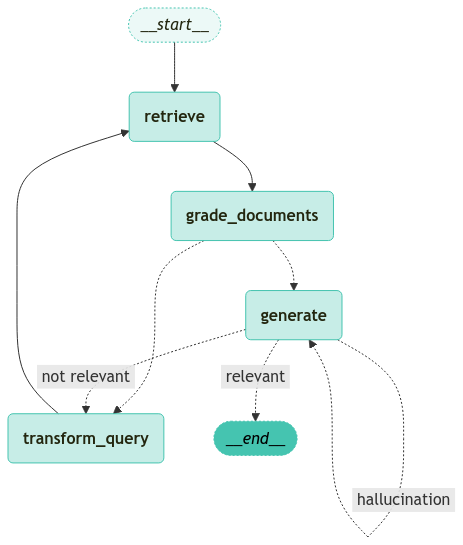

In [24]:
from graphs import visualize_graph

visualize_graph(app)

#### 6. 실행

In [25]:
from langchain_core.runnables import RunnableConfig
from langchain_print import stream_graph, invoke_graph, random_uuid

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = {
    "question": "AI 위험 유형은?",
}

# 그래프 실행
invoke_graph(
    app, inputs, config, ["retrieve", "transform_query", "grade_documents", "generate"]
)


🔄 Node: retrieve 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
page_content='SPRi 이슈리포트IS-183 AI 위험유형및사례분석
<표 2-4> AI 위험 요인 분류 및 범위
AI 위험 주요 자료
요슈아 벤지오 NIST
대분류 중분류 MIT 연구진14 Yi Zeng 외16
외12 AI RMF13
ㅇ 가짜 콘텐츠를 통한 개인 위해11
● ◑ ● ●
(사기, 피싱, 합성, 복제)
ㅇ 허위 정보 생성11,12,13
● ● ● ◑
(광고, 마이크로 타게팅)
ㅇ 사용자 설득 및 여론 조작11
● ● ◑ ●
악의적 사용 (대화형 AI를 통한 설득)
위험 ㅇ 사이버 공격 및 보안11,15 ● ● ● ●' metadata={'source': './data/IS-183_AI 위험 유형 및 사례 분석(최종).pdf', 'file_path': './data/IS-183_AI 위험 유형 및 사례 분석(최종).pdf', 'page': 14, 'total_pages': 32, 'Author': 'user', 'Creator': 'Hwp 2018 10.0.0.14241', 'Producer': 'Hancom PDF 1.3.0.547', 'CreationDate': "D:20241106094709+09'00'", 'ModDate': "D:20241106094709+09'00'", 'PDFVersion': '1.4'}
page_content='위험이 존재하나, 기존의 기술 도구로는 의미 있는 보호가 어려운 상황
<표 2-1> 요슈아 벤지오 연구팀의 AI 위험 분류 및 주요 내용
대분류 중분류 주요 내용
-강화된 피싱 등의 공격을 통한 사기
가짜 콘텐츠를 통한 개인에 대한 피해
-개인 동의 없는 가짜 콘텐츠 생성
악의적 사용 위험 허위 정보 및 여론 조작 -허위 정보 생성 및 전파
(Malicious use -전문지식 제공을 통한 사이버 공격 지원
사이버 공격
risks) -사이버보안 작업 자동화 가능성에 따른 위험


재귀에 빠질 수 있는 경우에는 `GraphRecursionError` 처리를 꼭 해주어 루프를 빠져나올 수 있어야 합니다.

In [27]:
from langgraph.errors import GraphRecursionError

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = {
    "question": "JUNE이 개발한 생성형 AI 의 이름은?",
}

try:
    # 그래프 실행
    stream_graph(
        app,
        inputs,
        config,
        ["retrieve", "transform_query", "grade_documents", "generate"],
    )
except GraphRecursionError as recursion_error:
    print(f"GraphRecursionError: {recursion_error}")


🔄 Node: grade_documents 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
==== [DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY] ====

🔄 Node: transform_query 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
JUNE이 개발한 생성형 AI의 정확한 이름은 무엇인가요?
🔄 Node: grade_documents 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
==== [DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY] ====

🔄 Node: transform_query 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
JUNE이 개발한 생성형 AI의 공식 명칭은 무엇인가요?
🔄 Node: grade_documents 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
==== [DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY] ====

🔄 Node: transform_query 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
JUNE이 개발한 생성형 AI의 공식 명칭은 무엇인지 알려주세요.GraphRecursionError: Recursion limit of 10 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: ht